In [29]:
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import cufflinks as cf
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
from glob import glob
import plotly.graph_objects as go

In [9]:
init_notebook_mode(connected=True)

In [2]:
# input traj_name, output group name, version and R[innner5/medium10/outer20]
def get_group_v_R(traj_name):
    n1 = int(traj_name[-6])
    n2 = traj_name[-5]
    if n2 == 'o':
        R = 20
    elif n2 == 'm':
        R = 10
    elif n2 == 'i':
        R = 5
        
    group_set, version = list(traj_name.split('-'))[0], list(traj_name.split('-'))[1]
    group_set = list(group_set.split('test'))[-1]
    group = list(group_set.split(','))[n1-1]
    
    return int(group), version, R

In [3]:
# input group name, output printing temperature, printing speed, fibre feed rate and nylon feed rate
def get_paras(group):
    params = pd.read_excel('AP summary.xlsx', sheet_name='Sheet2')
    p_tem = params[params['No.'] == group]['Printing Temperature'].to_numpy()[0]
    p_speed = params[params['No.'] == group]['Printing Speed'].to_numpy()[0]
    f_rate = params[params['No.'] == group]['Fibre Feed rate'].to_numpy()[0]
    n_rate = params[params['No.'] == group]['Nylon Feed rate'].to_numpy()[0]
    return p_tem, p_speed, f_rate, n_rate

# get_paras(get_group_v_R('croped_test1,2,3,4-v1-1i.bmp')[0])

In [4]:
# input AP sammary excel, output df {printing temperature, printing speed, fibre feed rate, nylon feed rate, R, version, APs}
def rearragen_AP_excel(excel_name):
    df = pd.read_excel(excel_name, sheet_name='Sheet1')
    versions = []
    Rs = []
    p_tems = []
    p_speeds = []
    f_rates = []
    n_rates = []
    names = list(df['Pic_name'])
#     AP_befores = list(df['AP_before'])
#     AP_arcs = list(df['AP_arc'])
#     AP_afters = list(df['AP_after'])
    for name in names:
        group, version, R = get_group_v_R(name)
        versions.append(version)
        Rs.append(R)
        p_tem, p_speed, f_rate, n_rate = get_paras(group)
        p_tems.append(p_tem)
        p_speeds.append(p_speed)
        f_rates.append(f_rate)
        n_rates.append(n_rate)
    scores = list(df['AP_before']) + list(df['AP_arc']) + list(df['AP_after'])
    sections = ['AP_before'] * len(names) + ['AP_arc'] * len(names) + ['AP_after'] * len(names)
    p_tems = p_tems *3
    p_speeds = p_speeds *3
    f_rates = f_rates *3
    n_rates = n_rates *3
    Rs = Rs *3
    versions = versions *3
    new_df = pd.DataFrame({'printing_temperature': p_tems, 'printing_speed': p_speeds, 'fibre_feed_rate': f_rates, 
                           'nylon_feed_rate': n_rates, 'Radius': Rs, 'Version': versions, 
                           'Score': scores, 'Section': sections})
    return new_df
# df = rearragen_AP_excel('AP summary.xlsx')
# df.to_excel('ori_parameter_AP_summary.xlsx')

In [21]:
# Importing libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
  
# Performing two-way ANOVA
model = ols(
    'Score ~ C(printing_temperature)+C(printing_speed)+C(fibre_feed_rate)+C(nylon_feed_rate)+C(Radius)+C(Section)+\
    C(Section):C(printing_temperature)+C(Section):C(printing_speed)+C(Section):C(fibre_feed_rate)+C(Section):C(nylon_feed_rate)+\
    C(Section):C(Radius)+C(Radius):C(printing_temperature)+C(Radius):C(printing_speed)+C(Radius):C(fibre_feed_rate)+\
    C(Radius):C(nylon_feed_rate)+C(printing_temperature):C(printing_speed)+C(printing_temperature):C(fibre_feed_rate)+C(printing_temperature):C(nylon_feed_rate)+\
    C(printing_speed):C(fibre_feed_rate)+C(printing_speed):C(nylon_feed_rate)+C(fibre_feed_rate):C(nylon_feed_rate)\
    ', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(printing_temperature),0.059224,3.0,0.825171,4.805315e-01
C(printing_speed),0.030735,3.0,0.428231,7.328761e-01
C(fibre_feed_rate),2.553780,3.0,35.581909,1.751643e-20
C(nylon_feed_rate),0.017577,3.0,0.244904,8.649550e-01
C(Radius),1.768427,2.0,36.959334,1.691927e-15
C(Section),17.513222,2.0,366.018586,2.413517e-92
Residual,9.928440,415.0,NaN,NaN


In [56]:
df = pd.read_excel('parameter_AP_summary.xlsx', sheet_name='Sheet1')

In [57]:
df.head()

,Printing Temperature,Printing Speed,Fibre Feed Rate,Nylon Feed Rate,Radius,Version,Score,Section,Arc Printing Speed,Arc Fibre Feed Rate,Arc Nylon Feed Rate
0,240,120,1.0,1.0,5,v1,0.871887,AP_before,120,0.8,0.6
1,240,120,1.0,1.0,10,v1,0.938283,AP_before,120,0.8,0.6
2,240,120,1.0,1.0,20,v1,0.958136,AP_before,120,0.8,0.6
3,240,120,1.0,1.0,5,v1,0.876785,AP_before,280,0.9,0.8
4,240,120,1.0,1.0,10,v1,0.938635,AP_before,280,0.9,0.8


In [104]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]])

# Generate data
# factor1 = 'Arc Printing Speed'
# factor2 = 'Arc Fibre Feed Rate'

mean_df = df[df['Section']=='AP_before'].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")
fig.add_trace(go.Surface(z=flights.values, ),#colorscale='Viridis',
             row=1, col=1)

mean_df = df[df['Section']=='AP_arc'].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")
fig.add_trace(go.Surface(z=flights.values, ),#colorscale='Viridis',
             row=1, col=2)

mean_df = df[df['Section']=='AP_after'].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")
fig.add_trace(go.Surface(z=flights.values, ),#colorscale='Viridis',
             row=1, col=3)

# Update xaxis properties
# fig.update_xaxes(title_text="Arc Printing Speed", row=1, col=1)
# fig.update_xaxes(title_text="Arc Printing Speed", range=[10, 50], row=1, col=2)
# fig.update_xaxes(title_text="Arc Printing Speed", showgrid=False, row=1, col=3)

# # Update yaxis properties
# fig.update_yaxes(title_text="Arc Fibre Feed Rate", row=1, col=1)
# fig.update_yaxes(title_text="Arc Fibre Feed Rate", range=[40, 80], row=1, col=2)
# fig.update_yaxes(title_text="Arc Fibre Feed Rate", showgrid=False, row=1, col=3)

# Update yaxis properties
# fig.update_zaxes(title_text="AP Value", range=[0.2, 1], row=1, col=1)
# fig.update_zaxes(title_text="AP Value", range=[0.2, 1], row=1, col=2)
# fig.update_zaxes(title_text="AP Value", range=[0.2, 1], row=1, col=3)

# fig.update_layout(zaxis=dict(tickvals=[0.2, 0.4, 0.6, 0.8, 1]),
#                  zaxis2=dict(tickvals=[0.2, 0.4, 0.6, 0.8, 1]),
#                  zaxis3=dict(tickvals=[0.2, 0.4, 0.6, 0.8, 1]),
#                  )

fig.update_layout(scene = dict(zaxis = dict(nticks=4, range=[0.2,1],tickvals=[0.2, 0.4, 0.6, 0.8, 1]),),)
fig.update_layout(scene2 = dict(zaxis = dict(nticks=4, range=[0.2,1],tickvals=[0.2, 0.4, 0.6, 0.8, 1]),),)
fig.update_layout(scene3 = dict(zaxis = dict(nticks=4, range=[0.2,1],tickvals=[0.2, 0.4, 0.6, 0.8, 1]),),)

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=400,
    width=1000
)

fig.show()

In [95]:
factor1 = 'Arc Printing Speed'
factor2 = 'Arc Fibre Feed Rate'

mean_df = df[df['Section']=='AP_after'].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")
fig = go.Figure(data=[go.Surface(z=flights.values)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [17]:
a5_df = df[(df['Section']=='AP_arc') & (df['Radius']==5)]
a10_df = df[(df['Section']=='AP_arc') & (df['Radius']==10)]
a20_df = df[(df['Section']=='AP_arc') & (df['Radius']==20)]

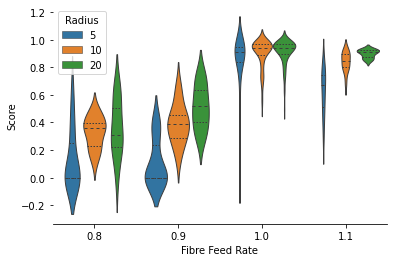

In [81]:
sns.violinplot(data=df, x="Fibre Feed Rate", y="Score", hue="Radius",inner="quart", linewidth=1,)
#                split=True, palette={"Yes": "b", "No": ".85"})
sns.despine(left=True)

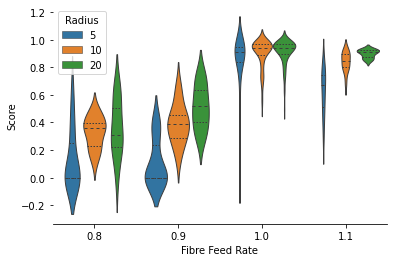

In [56]:
sns.violinplot(data=df, x="Fibre Feed Rate", y="Score", hue="Radius",
               inner="quart", linewidth=1,)
#                split=True, palette={"Yes": "b", "No": ".85"})
sns.despine(left=True)

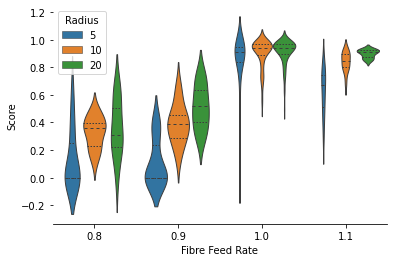

In [56]:
sns.violinplot(data=df, x="Fibre Feed Rate", y="Score", hue="Radius",
               inner="quart", linewidth=1,)
#                split=True, palette={"Yes": "b", "No": ".85"})
sns.despine(left=True)

In [20]:
# Get df groupby different printing temperature

column = 'Section'
performance1 = list(df[df[column]=='AP_before']['Score'])
performance2 = list(df[df[column]=='AP_arc']['Score'])
performance3 = list(df[df[column]=='AP_after']['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3,)

C:\Users\LocalAdmin\anaconda3\lib\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [39]:
# Get df groupby different printing temperature
df = a20_df
column = 'Radius'
performance1 = list(df[df[column]==5]['Score'])
performance2 = list(df[df[column]==10]['Score'])
performance3 = list(df[df[column]==20]['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3,)

F_onewayResult(statistic=nan, pvalue=nan)

In [40]:
# Get df groupby different printing temperature
column = 'Printing Temperature'
performance1 = list(df[df[column]==240]['Score'])
performance2 = list(df[df[column]==250]['Score'])
performance3 = list(df[df[column]==260]['Score'])
performance4 = list(df[df[column]==270]['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

F_onewayResult(statistic=0.11197752628910111, pvalue=0.9514274278606899)

In [41]:
# Get df groupby different parameters
column = 'Printing Speed'
performance1 = list(df[df[column]==120]['Score'])
performance2 = list(df[df[column]==280]['Score'])
performance3 = list(df[df[column]==440]['Score'])
performance4 = list(df[df[column]==600]['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

F_onewayResult(statistic=0.4692957969692555, pvalue=0.7092078403819962)

In [42]:
# Get df groupby different parameters
column = 'Fibre Feed Rate'
performance1 = list(df[df[column]==0.8]['Score'])
performance2 = list(df[df[column]==0.9]['Score'])
performance3 = list(df[df[column]==1]['Score'])
performance4 = list(df[df[column]==1.1]['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

F_onewayResult(statistic=20.397873609612287, pvalue=5.279461892271928e-05)

In [43]:
# Get df groupby different parameters
column = 'Nylon Feed Rate'
performance1 = list(df[df[column]==0.6]['Score'])
performance2 = list(df[df[column]==0.8]['Score'])
performance3 = list(df[df[column]==1]['Score'])
performance4 = list(df[df[column]==1.2]['Score'])
# Conduct the one-way ANOVA
f_oneway(performance1, performance2, performance3, performance4)

F_onewayResult(statistic=0.0870459805210311, pvalue=0.9657992714782964)

In [33]:
mean_df = df.groupby(['Printing Temperature', 'Printing Speed','Fibre Feed Rate'\
                      ,'Nylon Feed Rate','Arc Printing Speed','Arc Fibre Feed Rate',\
                      'Arc Nylon Feed Rate','Radius','Section']).mean()
# mean_df.to_excel('Grouped_AP_summary.xlsx')

In [34]:
new_df = mean_df.reset_index()
new_df.head()

,Printing Temperature,Printing Speed,Fibre Feed Rate,Nylon Feed Rate,Arc Printing Speed,Arc Fibre Feed Rate,Arc Nylon Feed Rate,Radius,Section,Score
0,240,120,0.8,0.6,120,0.8,0.6,5,AP_arc,0.350079
1,240,120,0.8,0.6,120,0.8,0.6,10,AP_arc,0.395861
2,240,120,0.8,0.6,120,0.8,0.6,20,AP_arc,0.507738
3,240,120,1.0,1.0,120,0.8,0.6,5,AP_after,0.825531
4,240,120,1.0,1.0,120,0.8,0.6,5,AP_before,0.906179


In [13]:
arc_df = new_df[(new_df['Section']=='AP_arc')]

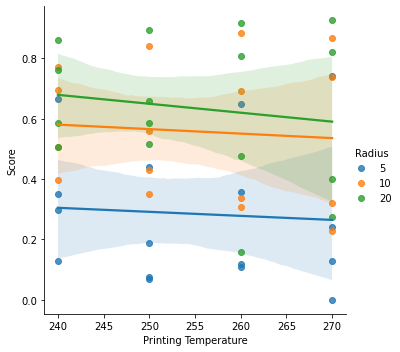

In [16]:
# sns.set_theme(style="ticks")
# df = pd.read_excel('New_AP_summary.xlsx', sheet_name='Sheet1')
# Load the penguins dataset
# penguins = sns.load_dataset(df)

# Show the joint distribution using kernel density estimation
g = sns.lmplot(
    data=arc_df,
    x="Printing Temperature", y="Score", hue="Radius",
    height=5
)

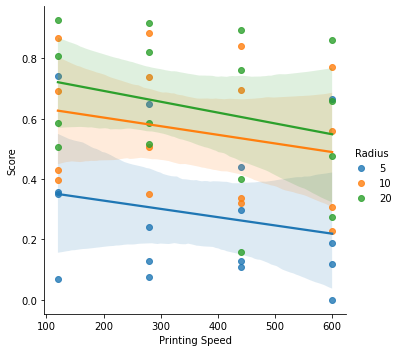

In [17]:
# sns.set_theme(style="ticks")
# df = pd.read_excel('New_AP_summary.xlsx', sheet_name='Sheet1')
# Load the penguins dataset
# penguins = sns.load_dataset(df)

# Show the joint distribution using kernel density estimation
g = sns.lmplot(
    data=arc_df,
    x="Printing Speed", y="Score", hue="Radius",
    height=5
)

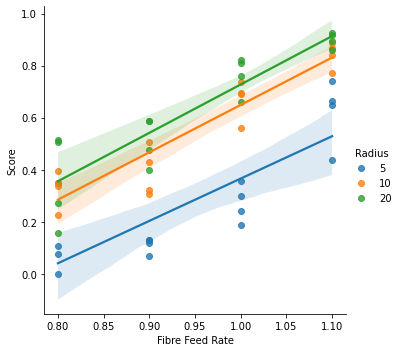

In [18]:
# sns.set_theme(style="ticks")
# df = pd.read_excel('New_AP_summary.xlsx', sheet_name='Sheet1')
# Load the penguins dataset
# penguins = sns.load_dataset(df)

# Show the joint distribution using kernel density estimation
g = sns.lmplot(
    data=arc_df,
    x="Fibre Feed Rate", y="Score", hue="Radius",
    height=5
)

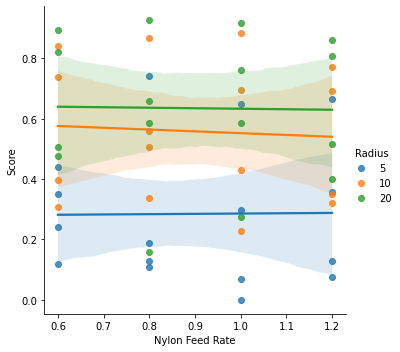

In [19]:
# sns.set_theme(style="ticks")
# df = pd.read_excel('New_AP_summary.xlsx', sheet_name='Sheet1')
# Load the penguins dataset
# penguins = sns.load_dataset(df)

# Show the joint distribution using kernel density estimation
g = sns.lmplot(
    data=arc_df,
    x="Nylon Feed Rate", y="Score", hue="Radius",
    height=5
)

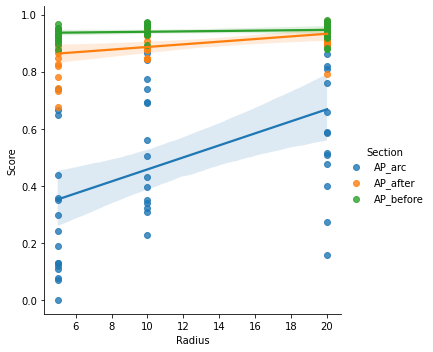

In [52]:
# sns.set_theme(style="ticks")
# df = pd.read_excel('New_AP_summary.xlsx', sheet_name='Sheet1')
# Load the penguins dataset
# penguins = sns.load_dataset(df)

# Show the joint distribution using kernel density estimation
g = sns.lmplot(
    data=new_df,
    x="Radius", y="Score", hue="Section",
    height=5
)

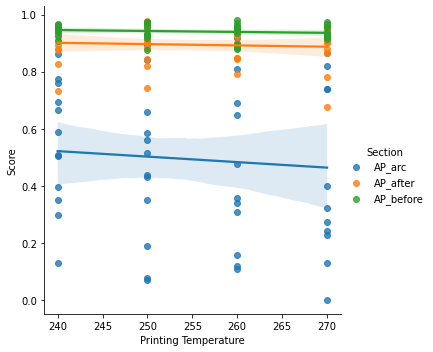

In [54]:

g = sns.lmplot(
    data=new_df,
    x="Printing Temperature", y="Score", hue="Section",
    height=5
)

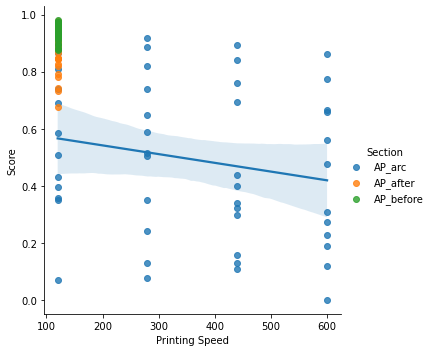

In [55]:

g = sns.lmplot(
    data=new_df,
    x="Printing Speed", y="Score", hue="Section",
    height=5
)

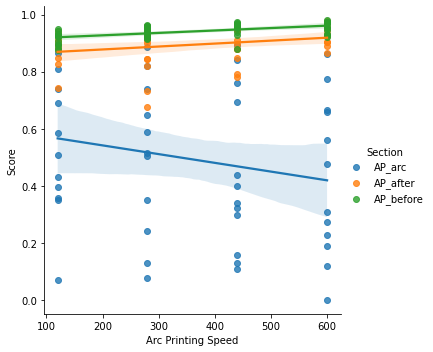

In [56]:

g = sns.lmplot(
    data=new_df,
    x="Arc Printing Speed", y="Score", hue="Section",
    height=5
)

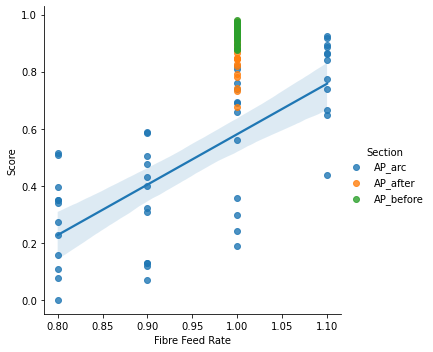

In [57]:

g = sns.lmplot(
    data=new_df,
    x="Fibre Feed Rate", y="Score", hue="Section",
    height=5
)

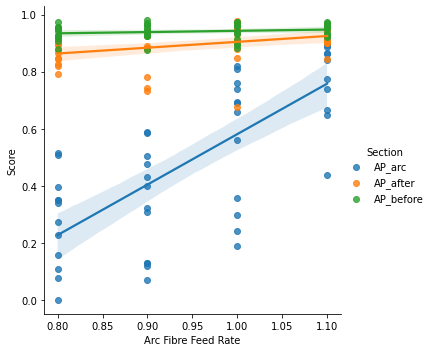

In [58]:

g = sns.lmplot(
    data=new_df,
    x="Arc Fibre Feed Rate", y="Score", hue="Section",
    height=5
)

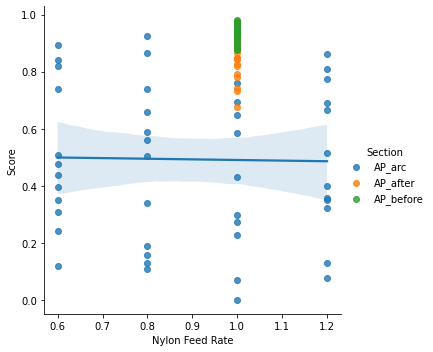

In [59]:

g = sns.lmplot(
    data=new_df,
    x="Nylon Feed Rate", y="Score", hue="Section",
    height=5
)

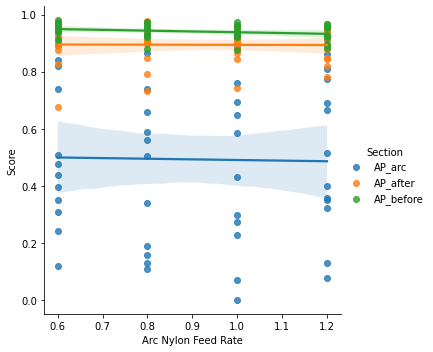

In [60]:

g = sns.lmplot(
    data=new_df,
    x="Arc Nylon Feed Rate", y="Score", hue="Section",
    height=5
)

<AxesSubplot:xlabel='Fibre Feed Rate', ylabel='Printing Speed'>

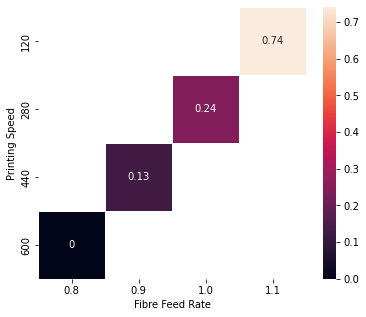

In [42]:
# plot diagrams
factor1 = 'Printing Speed'
factor2 = 'Fibre Feed Rate'

mean_df = a5_df[a5_df['Printing Temperature']==270].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

In [43]:
flights

Fibre Feed Rate,0.8,0.9,1.0,1.1
Printing Speed,,,,
120,NaN,NaN,NaN,0.740652
280,NaN,NaN,0.241189,NaN
440,NaN,0.129064,NaN,NaN
600,0.0,NaN,NaN,NaN


<AxesSubplot:xlabel='Fibre Feed Rate', ylabel='Printing Speed'>

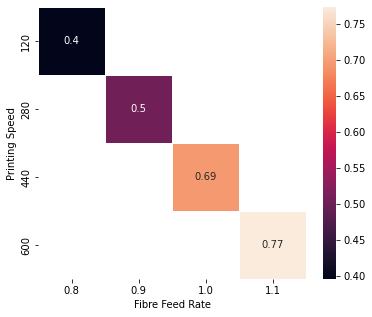

In [52]:
# plot diagrams
factor1 = 'Printing Speed'
factor2 = 'Fibre Feed Rate'

mean_df = a10_df[a10_df['Printing Temperature']==240].groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='Section', ylabel='Arc Printing Speed'>

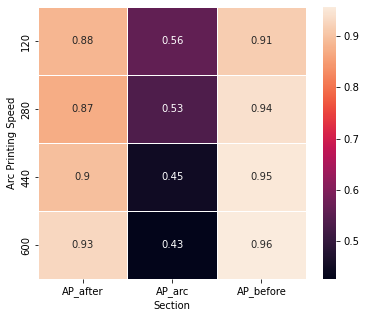

In [61]:
# plot diagrams
factor1 = 'Arc Printing Speed'
factor2 = 'Section'
mean_df = df.groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='Section', ylabel='Arc Fibre Feed Rate'>

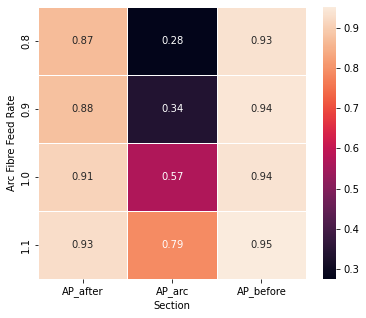

In [62]:
# plot diagrams
factor1 = 'Arc Fibre Feed Rate'
factor2 = 'Section'
mean_df = df.groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='Printing Speed', ylabel='Radius'>

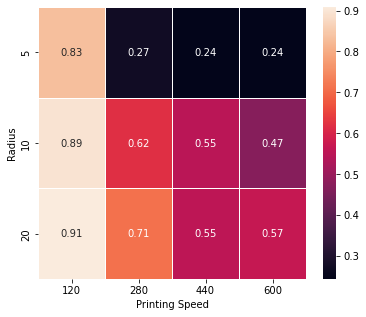

In [64]:
# plot diagrams
factor1 = 'Radius'
factor2 = 'Printing Speed'
mean_df = df.groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='fibre feed rate', ylabel='Radius'>

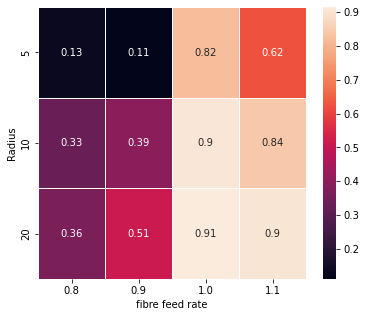

In [26]:
# plot diagrams
factor1 = 'Radius'
factor2 = 'fibre feed rate'
mean_df = df.groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='fibre feed rate', ylabel='printing speed'>

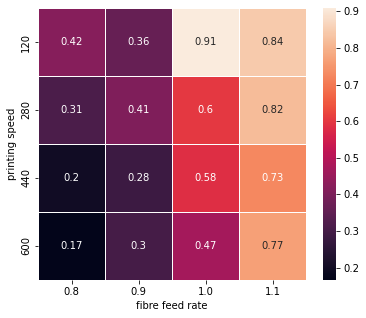

In [27]:
# plot diagrams
factor1 = 'printing speed'
factor2 = 'fibre feed rate'
mean_df = df.groupby([factor1,factor2]).mean().reset_index()
flights = mean_df.pivot(factor1,factor2, "Score")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='printing speed', ylabel='printing temperature'>

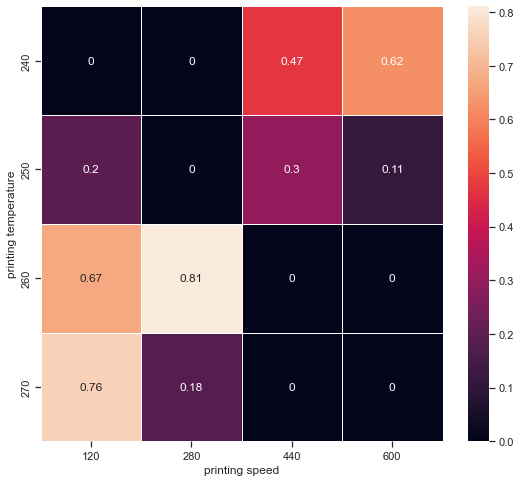

In [69]:
# plot diagrams

# sns.set_theme(style="ticks")
df = pd.read_excel('parameter_AP_summary.xlsx', sheet_name='Sheet2')

flights = df.pivot("printing temperature", "printing speed", "AP_arc")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

<AxesSubplot:xlabel='printing speed', ylabel='printing temperature'>

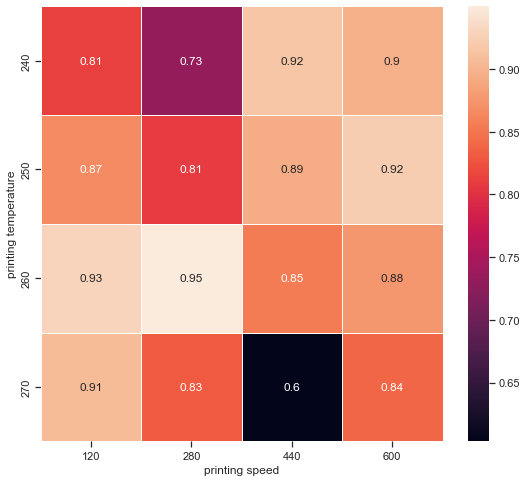

In [70]:
# plot diagrams

# sns.set_theme(style="ticks")
df = pd.read_excel('parameter_AP_summary.xlsx', sheet_name='Sheet2')

flights = df.pivot("printing temperature", "printing speed", "AP_after")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(flights, annot=True,linewidths=.5, ax=ax)# fmt="d", 

In [2]:
# best fiber extraction: Threshold Binary70 + Guassian Otsu's Thresholding
# best centre line: Threshold Binary70inv + closing + skel + remove small 1 contours
# 先threshould 根据边界框框crop crop完了直接用binary的图片提取12个trajectory 然后每个trajetory和GT的进行
# overlay 计算不同粗细的precision
# 还有一个metric就是RMSE计算pred每个pixel的位置和最近的GT的pixel的欧拉距离 但是不是很好算 要么就算了。
# 应该先提取fiber 然后croped了再分别不同trajectory再识别中心线 没有合适的metric就是说。

In [2]:
# 提取fiber部分
def extract_cline_fiber(pic):
    ret,thresh1 = cv2.threshold(pic, 210, 255, cv2.THRESH_BINARY_INV)
    blur = cv2.GaussianBlur(thresh1, (5,5), 0)#blur的size可以修改
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

In [6]:
# 提取12个图片的黑白版本
# files = glob('12 fiber pics\\*.*')
# for file in files:
#     name = list(file.split('\\'))[-1]
#     pic = cv2.imread(file, 0)
#     new_pic = extract_cline_fiber(pic)
#     cv2.imwrite('12 fiber pics\\extracted_' + name, new_pic)

In [10]:
# 根据12个图片的分别的每个trajectory的涂抹消除版本提取出本来的面目
def get_xor_traj(pic_name):
    pic = cv2.imread('12 fiber pics\\' + pic_name, 0)
    ori_name = pic_name[:-7]
    ori_pic = cv2.imread('12 fiber pics\\' + ori_name + '.bmp', 0)
    new_pic = ori_pic - pic
    cv2.imwrite('trajectorys\\' + pic_name, new_pic)
    
# files = glob('12 fiber pics\\*.*')
# for file in files:
#     name = list(file.split('\\'))[-1]
#     if (name[-5] == 'i') or (name[-5] == 'm') or (name[-5] == 'o'):
#         get_xor_traj(name)

In [19]:
# 将修改好的trajectory图片改成binary
def convert_binary(pic_name):
    pic = cv2.imread('fixed_trajectorys\\' + pic_name, 0)
    new_pic =  (np.round(pic//255.))*255
    cv2.imwrite('binary_trajectorys\\' + pic_name, new_pic)
    
# files = glob('fixed_trajectorys\\*.*')
# for file in files:
#     name = list(file.split('\\'))[-1]
#     convert_binary(name)

test13,14,15,16-v3.bmp


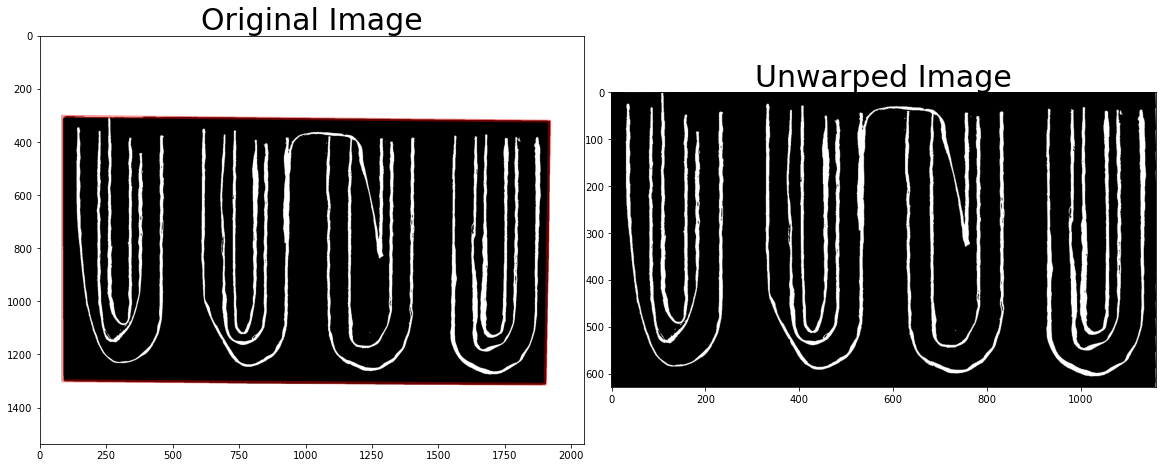

True

In [44]:
# 根据框截图图片的function 从image变成croped
# source code from https://stackoverflow.com/questions/22656698/perspective-correction-in-opencv-using-python
# four corner pixel location found manually with https://yangcha.github.io/iview/iview.html
def unwarp(img, src, dst):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (1160, 630), flags=cv2.INTER_LINEAR)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.subplots_adjust(hspace=.2, wspace=.05)
    ax1.imshow(img)
    x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
    y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]
    ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_ylim([h, 0])
    ax1.set_xlim([0, w])
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.flip(warped, 1))
    ax2.set_title('Unwarped Image', fontsize=30)
    plt.show()
    return cv2.rotate(cv2.flip(warped, 1), cv2.ROTATE_180)
#     else:
#         return warped, M

name = 'extracted_test13,14,15,16-v3.bmp'
im = cv2.imread("12 fiber pics\\" + name)
orgi_name = list(name.split('_'))[-1]
print(orgi_name)
# w, h = im.shape[0], im.shape[1]
# We will first manually select the source points 
# we will select the destination point which will map the source points in
# original image to destination points in unwarped image

src = np.float32([(86, 304),
                  (1918, 322),
                  (86, 1299),
                  (1902, 1312)])

dst = np.float32([(1160, 0),
                  (0, 0),
                  (1160, 630),
                  (0, 630)])

warped = unwarp(im, src, dst)

cv2.imwrite("12 fiber pics\\croped_" + orgi_name, warped)

In [3]:
# 根据evaluate的曲线位置（0-11）和evaluate的range（1,2,3意味着几倍）生成取样区域
def eva_area(img, pos=1, rang=1):
    
    num = pos//3
    loc = pos%3
    center = 130+300*num
    pic = np.zeros([630, 1165])# 这里为了calibrate改了宽度
    if loc == 2:
        R = 25
    elif loc == 1:
        R = 50
    elif loc == 0:
        R = 100
    
    thick = np.round(rang*6.5).astype(int)
    cv2.circle(pic, (center,130), R, 255, thick)
    cv2.rectangle(pic, (center-R-thick,130), (center+R+thick,130+R+thick), 0, -1)
    cv2.line(pic, (center-R,130), (center-R,130+470), 255, thick) 
    cv2.line(pic, (center+R,130), (center+R,130+470), 255, thick) 
    
    if img.shape[1]/img.shape[0] != 116/63:
        print('Image shape is not defult:', img.shape)
    pic = np.round(cv2.resize(pic, (img.shape[1],img.shape[0]))/255.)*255
    
    return pic

In [4]:
# 输入一个trajectory图片和一个GT图片 输出precision
def calc_pres(GT, pred):
    GT = np.round(GT/255.).astype(int)
    pred = np.round(pred/255.).astype(int)
    tot = np.count_nonzero(pred)
    TP = np.count_nonzero(GT&pred)

    if tot > 0:
        return TP/tot
    else:
        print('Print is too bad, please ditch this trajectory.')
        return 0

In [5]:
# 输入名字 输出pos, x, y
def get_numbers(traj_name):
    pred = cv2.imread('binary_trajectorys\\' + traj_name, 0)
    height, width = pred.shape[0],pred.shape[1]
    
    n1 = int(traj_name[-6])
    n2 = traj_name[-5]
    if n2 == 'o':
        n2 = 0
    elif n2 == 'm':
        n2 = 1
    elif n2 == 'i':
        n2 = 2
    pos = (n1-1)*3+n2
    x = 130+300*(pos//3)
    y = int(13/63*height)
    
    return pos, x, y

In [6]:
# 计算整个trajectory的AP
# 输入一个trajectory的图片名 输出从range1-5曲线下的面积
def get_AP(traj_name):
    AP = 0
    pred = cv2.imread('binary_trajectorys\\' + traj_name, 0)
    pos, _, _ = get_numbers(traj_name)

    for i in range(5):
        GT = eva_area(pred, pos, i+1)
        Pres = calc_pres(GT, pred)
        AP += Pres*0.2
        if i == 4 and Pres < 0.99:
            print(str(traj_name[-6:-4]), 'This trajectory requires larger range.')
    return AP

In [7]:
# 计算某个trajectory单个section的AP
# 输入12个叠在一起的trajectory图片，某trajectory的位置和哪部分线段（前，中，后） 输出从range1-5曲线下的面积
def get_AP_section(traj_name, section='arc'):
    AP = 0
    pred = cv2.imread('binary_trajectorys\\' + traj_name, 0)
    pos, x, y = get_numbers(traj_name)
    
    height, width = pred.shape
    for i in range(5):
        GT = eva_area(pred, pos, i+1)
        if section == 'arc':
            pred_s = pred[:y, :]
            GT_s = GT[:y, :]
        elif section == 'before':
            pred_s = pred[y:, :x]
            GT_s = GT[y:, :x]
        elif section == 'after':
            pred_s = pred[y:, x:]
            GT_s = GT[y:, x:]
        else:
            print('Please input before, arc or after in section.')
        cv2.imwrite('GTtest.png', GT_s)
        cv2.imwrite('Predtest.png', pred_s)
        Pres = calc_pres(GT_s, pred_s)
        AP += Pres*0.2
        if i == 4 and Pres < 0.99:
            print(str(traj_name[-6:-4]), 'This trajectory requires larger range.')
    return AP

In [8]:
# 可视化单个trajectory AP并分割三个区域，打上AP score
def view_AP(traj_name, rang=1):
    pred = cv2.imread('binary_trajectorys\\' + traj_name, 0)
    height, width = pred.shape[0],pred.shape[1]
    blk = np.zeros([height, width])
    text_blk = np.zeros([width, height,3])
    pos, x, y = get_numbers(traj_name)
    
    GT = eva_area(pred, pos, rang)
    pred = pred.reshape([height, width,1])
    GT = GT.reshape([height, width,1])
    blk = blk.reshape([height, width,1])
    
    AP_before = get_AP_section(traj_name, section='before')
    AP_arc = get_AP_section(traj_name, section='arc')
    AP_after = get_AP_section(traj_name, section='after')

    overlay = np.concatenate([blk, pred, GT], axis=-1)
    cv2.line(overlay, (x, y), (x, height), (255,255,255), 1) 
    cv2.line(overlay, (0, y), (width, y), (255,255,255), 1) 

    cv2.putText(text_blk, 'BeforeAP:' + str(round(AP_before, 2)), (200, x-110), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(overlay, 'ArcAP:' + str(round(AP_arc, 2)), (x-60, 20), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(text_blk, 'AfterAP:' + str(round(AP_after, 2)), (200, x+120), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (255,255,255), 1, cv2.LINE_AA)
    text_blk = cv2.rotate(text_blk, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    overlay = overlay + text_blk
    
#     cv2.imshow(str(traj_name), overlay)
#     cv2.waitKey(0)
    return AP_before, AP_arc, AP_after, overlay   

In [14]:
# 图也保存数据保存excel
# names = []
# APs_before = []
# APs_arc = []
# APs_after = []
# files = glob('binary_trajectorys\\*.*')
# for file in files:
#     name = list(file.split('\\'))[-1]
#     names.append(name)
#     AP_before, AP_arc, AP_after, overlay = view_AP(name, rang=1)
#     APs_before.append(AP_before)
#     APs_arc.append(AP_arc)
#     APs_after.append(AP_after)
#     cv2.imwrite('AP_results\\' + name, overlay)
    
# df = pd.DataFrame({'Pic_name': names, 'AP_before': APs_before, 'AP_arc': APs_arc, 'AP_after': APs_after})
# df.to_excel('AP summary.xlsx')

In [183]:
# 用来debug的生成的GT，一会儿就删
# pic = np.zeros([630, 1165])
# for pos in range(12):
#     num = pos//3
#     loc = pos%3
#     center = 130+300*num
    
#     if loc == 2:
#         R = 25
#     elif loc == 1:
#         R = 50
#     elif loc == 0:
#         R = 100
    
#     thick = np.round(6.5).astype(int)
#     cv2.circle(pic, (center,130), R, 255, thick)
#     cv2.rectangle(pic, (center-R-thick,130), (center+R+thick,130+R+thick), 0, -1)
#     cv2.line(pic, (center-R,130), (center-R,130+470), 255, thick) 
#     cv2.line(pic, (center+R,130), (center+R,130+470), 255, thick) 

# GT = np.round(cv2.resize(pic, (1160,630))/255.)*255
# cv2.imwrite('GT.bmp', GT)

True

In [184]:
# 用来debug把GT和收集的数据重叠上看看的
# files = glob('12 fiber pics\\croped*.*')
# blk = np.zeros([630, 1160])
# for file in files:
#     name = list(file.split('\\'))[-1]
#     if name[-6] == 'v':
#         sample = cv2.imread(file, 0)
#         overlay = np.concatenate([blk.reshape([630, 1160,1]), sample.reshape([630, 1160,1]), GT.reshape([630, 1160,1])], axis=-1)
#         cv2.imwrite('trajectory_debug\\' + name, overlay)

In [3]:
# 不需要了
# 输入crop的binary图片，输出12个trajectory叠在一起的图和对应的
# def get_traj(pic):
#     contours, hierarchy = cv2.findContours(pic, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
#     lefts = []
#     trajs = np.zeros([pic.shape[0],pic.shape[1],12])
    
#     for i in range(len(sorted_contours)):
#         c = sorted_contours[i]
#         area = cv2.contourArea(c)
#         if (area < 100 and i < 12) or (area >= 100 and i >= 12):
#             print('Disconnection may exist! Please check!')
#         elif area >= 100 and i < 12:
#             traj = cv2.drawContours(np.zeros(pic.shape),[c],0,255,-1)
#             trajs[:,:,i] = traj
#             l = np.where(traj!=0)[1].min()
#             lefts.append(l)
#         else:
#             pass
    
#     ordered = np.zeros(trajs.shape)
#     n = 0
#     for i in np.argsort(np.array(lefts)):
#         ordered[:,:,n] = trajs[:,:,i]
#         n+=1
        
#     return ordered

In [7]:
# 从左到右四个是不同的参数 所以这部分用不到了
# 输入整个trajectory图片和该trajectory的位置 输出从range1-5曲线下的面积
# def get_meanAP(ordered, trajectory='outer'):
#     if trajectory == 'outer':
#         poses = np.array([0,3,6,9])
#     elif trajectory == 'middle':
#         poses = np.array([0,3,6,9])+1
#     elif trajectory == 'inner':
#         poses = np.array([0,3,6,9])+2
#     else:
#         print('Please define trajectory inner, middle or outer.')
#     APs = []
#     for pos in poses:
#         APs.append(get_AP(ordered[:,:,pos], pos))
#     return sum(APs)/len(APs)

In [6]:
# 旧的版本 现在应该没用了
# 根据evaluate的曲线位置和evaluate的range生成取样区域
# def eva_area(img, num=1, loc=1, thick=1):
#     center = 130+300*(num-1)
#     pic = np.zeros([630, 1160])
#     if loc == 1:
#         R = 25
#     elif loc == 2:
#         R = 50
#     elif loc == 3:
#         R = 100
#     else:
#         print('Please choose location 1, 2 or 3.')
        
#     cv2.circle(pic, (center,130), R, 255, thick)
#     cv2.rectangle(pic, (center-R-thick,130), (center+R+thick,130+R+thick), 0, -1)
#     cv2.line(pic, (center-R,130), (center-R,130+470), 255, thick) 
#     cv2.line(pic, (center+R,130), (center+R,130+470), 255, thick) 
    
#     if img.shape[1]/img.shape[0] != 116/63:
#         print('Image shape is not defult:', img.shape)
#     pic = np.round(cv2.resize(pic, (img.shape[1],img.shape[0]))/255.)*255
    
#     return pic

In [2]:
# 用来生成中心线的function
# 源代码来源 http://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html
# def Skeletonization(img):
#     size = np.size(img)
#     skel = np.zeros(img.shape,np.uint8)
#     element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
#     done = False

#     while( not done):
#         eroded = cv2.erode(img,element)
#         temp = cv2.dilate(eroded,element)
#         temp = cv2.subtract(img,temp)
#         skel = cv2.bitwise_or(skel,temp)
#         img = eroded.copy()

#         zeros = size - cv2.countNonZero(img)
#         if zeros==size:
#             done = True

#     return skel

In [48]:
# 好像没用了 只取最大面积的12个部分的话
# 移除只有一个pixel的噪音
# def remove_1_noise(pic):
#     contours, hierarchy = cv2.findContours(pic, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     threshold_blobs_area = 0

#     for i in range(1, len(contours)):
#         index_level = int(hierarchy[0][i][1])
#         if index_level <= i:
#             cnt = contours[i]
#             area = cv2.contourArea(cnt)
#             if area <= threshold_blobs_area:
#                 cv2.drawContours(pic, [cnt], -1, 0, -1, 1)
#     return pic

In [290]:
pic = cv2.imread('o1.bmp',0)
print(pic.shape)
skl = Skeletonization(pic)
# skl = remove_1_noise(skl)
cv2.imwrite('o1_clin.bmp', skl)

(630, 1160)


True

In [292]:
# for i in range(ordered.shape[2]):
#     traj = ordered[:,:,i]
#     print(traj.shape)
#     cline = Skeletonization(traj)
#     cv2.imwrite('traj_'+str(i) + '.png', traj)
#     cv2.imwrite('cline_'+str(i) + '.png', cline)

In [4]:
# 输入：原始图片 输出：fiber threshold和中心线
def extract_cline_fiber(pic):
    # 提取fiber部分
    ret,thresh1 = cv2.threshold(pic, 210, 255, cv2.THRESH_BINARY_INV)
    blur = cv2.GaussianBlur(thresh1, (5,5), 0)#blur的size可以修改
    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     cv2.imwrite("Guassian Otsu's Thresholding.bmp", th3) 
    
    # 提取centre line部分
    kernel = np.ones((5,5), np.uint8)
    ret,thresh1 = cv2.threshold(pic, 210, 255, cv2.THRESH_BINARY_INV)
    closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)
    skel = Skeletonization(closing)
    skel = remove_1_noise(skel)
    
    return th3, skel

In [5]:
# 一键提取center line和fiber的图
pic = cv2.imread('220704.bmp',0)
th3, skel = extract_cline_fiber(pic)
cv2.imwrite('220704fibre.bmp', th3)
cv2.imwrite('220704cline.bmp', skel)

True

In [7]:
def get_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas

In [15]:
# # 对提取的截取好的（一定和GT重合的）fiber图片进行contour分每个trajectory
# def get_trajectory(croped):
#     edged = cv2.Canny(np.uint8(croped), 50, 200)
#     contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
#     areas = get_contour_areas(sorted_contours)
#     blk_image = np.zeros(croped.shape)
#     if len(areas) > 12:
#         idx = 12-len(areas)
#         if np.any(np.array(areas[idx:]) > 100):
#             print('Disconnetion may exist, please check!')
#         else:
#             n = 0
#             for c in sorted_contours:
# #                 print(c)
#                 cv2.drawContours(blk_image, c, -1, 170, cv2.FILLED)
# #                 cv2.drawContours(blk_image,[c],0,(0,255,0),-1)
# #                 cv2.drawContours(blk_image, c, 0, 170, cv2.FILLED)
# #                 cv2.waitKey(0)
#                 cv2.imwrite('contour_' + str(n) + '.png', blk_image)
#                 n+=1
#     elif len(areas) < 12:
#         print('Only %d trajectory detected, please check!' %len(areas))
#     print (get_contour_areas(sorted_contours))
#     print ("Number of contours found = ", len(contours))

In [38]:
# 尝试画出来area的新的对提取的截取好的（一定和GT重合的）fiber图片进行contour分每个trajectory
def get_trajectory(croped):
#     print(np.unique(croped))
    edged = cv2.Canny(np.uint8(croped), 50, 200)
    ret,thresh1 = cv2.threshold(np.uint8(croped), 210, 255, cv2.THRESH_BINARY_INV)
    cv2.imwrite('thistimethresh1.png', thresh1)
#     contours, hierarchy = cv2.findContours(thresh1.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    areas = get_contour_areas(sorted_contours)
    blk_image = np.zeros(croped.shape)
    if len(areas) > 12:
        idx = 12-len(areas)
        if np.any(np.array(areas[idx:]) > 100):
            print('Disconnetion may exist, please check!')
        else:
            n = 0
            for c in sorted_contours:
#                 print(c)
                cv2.drawContours(blk_image, c, -1, 170, cv2.FILLED)
#                 cv2.drawContours(blk_image,[c],0,(0,255,0),-1)
#                 cv2.drawContours(blk_image, c, 0, 170, cv2.FILLED)
#                 cv2.waitKey(0)
                cv2.imwrite('contour_' + str(n) + '.png', blk_image)
                n+=1
    elif len(areas) < 12:
        print('Only %d trajectory detected, please check!' %len(areas))
    print (get_contour_areas(sorted_contours))
    print ("Number of contours found = ", len(contours))

In [39]:
get_trajectory(croped)

[8682.5, 8337.5, 8050.0, 7719.0, 7100.0, 6788.5, 6785.0, 6679.5, 6666.5, 6543.5, 6455.5, 5211.5, 13.0, 10.0, 4.0]
Number of contours found =  15


In [ ]:
# 根据生成的标准图片eva_area和输入图片计算该选中的area下的

True

In [40]:
# 这里是随便截取一下打印提取的图片 看能不能用来跟上面的eva area重合一下
# height, w = th3.shape
l,u = 100, 450
h = 1000
w = int(h/63*116)
croped = th3[u:u+h, l:l+w]
croped = np.round((cv2.resize(croped, (1160, 630)))/255.).astype(int)*255
# print(croped)
o1 = eva_area(croped,num=1, loc=3, thick=10).astype(int)
np.unique(o1)
cv2.imwrite('o1.bmp', o1)
cv2.imwrite('croped.bmp', croped)
added_image = cv2.addWeighted(croped,0.4,o1,0.3,0)
cv2.imwrite('overlay.bmp', added_image)

True

In [41]:
np.unique(croped)

array([  0, 255])

In [46]:
image = cv2.imread('d3d10597-e629-4f08-853b-75472ae0de06.bmp',0)
kernel = np.ones((5,5), np.uint8)
ret,thresh1 = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY_INV)
# Closing - for removing noise
# blur = cv2.GaussianBlur(image, (5,5), 0)
# _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
closing = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('Closing.bmp', closing)

skel = Skeletonization(closing)
cv2.imwrite('Closingskel.bmp', skel)

contours, hierarchy = cv2.findContours(skel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
threshold_blobs_area = 0

for i in range(1, len(contours)):
    index_level = int(hierarchy[0][i][1])
    if index_level <= i:
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        print(area)
        if area <= threshold_blobs_area:
            cv2.drawContours(skel, [cnt], -1, 0, -1, 1)
cv2.imwrite('removednoiseClosingskel.bmp', skel)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
15.5
1.5
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
3.0
8.5
14.5
0.0
8.5
0.0
0.0
0.0
0.0
0.0
0.0
5.0
5.0
0.0
10.5
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
33.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
46.0
0.0
11.5
11.0
0.0
24.0
35.5
0.0
16.0
40.0
0.0
0.0
0.0
0.0
3.5
3.5
2.0
0.0
0.0
32.0
0.0
0.0
0.0
0.0
23.0
14.5
0.0
80.0
0.0
0.0
6.0
1.0
0.0
0.0
0.0
45.0
110.0
0.0
0.0
48.5
33.0
25.0
22.5
107.0
35.0
0.0
0.0
0.0
0.0
0.0
7.0
2.0
0.0
0.0
30.0
74.0
0.0
40.0
8.5
0.5
0.0
0.0
61.0
0.0
95.5
39.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
41.0
0.0
74.5
0.0
16.5
0.0
0.0
0.0
58.0
0.0
2.5
0.0
0.0
0.0
2.5
0.0
69.0
0.0
0.0
0.0
0.0
1.0
0.0
71.0
55.5
0.0
3.0
0.0
0.0
0.0
48.0
0.0
0.0
84.0
97.0
0.0
33.0
0.0
2.5
82.0
107.0
0.0
0.0
14.5
10.0
0.0
68.0
47.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
157.0
0.0
0.0
0.0
0.0
0.0
14.0
33.0
32.5
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
12.5
0.0
0.0
0.0
0.0
0.0
24.0
0.0
6.0
0.0
205.5
81.0
111.5
0.0
74.0
83.5
0.0
290.0
0.0
206.0
1

True

In [12]:
img = cv2.imread('d3d10597-e629-4f08-853b-75472ae0de06.bmp',0)
img = cv2.medianBlur(img,5)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
cv2.imwrite("ADAPTIVE_THRESH_GAUSSIAN Thresholding.bmp", th3) 

True

In [32]:
image = cv2.imread('Threshold Binary70.bmp',0)
# It's good practice to blur images as it removes noise
image = cv2.GaussianBlur(image, (3, 3), 0)

# Using adaptiveThreshold
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                               cv2.THRESH_BINARY, 3, 5) 
cv2.imwrite("Adaptive Mean Thresholding.bmp", thresh) 
# cv2.waitKey(0) 

_, th2 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite("Otsu's Thresholding.bmp", th2) 
# cv2.waitKey(0) 

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(image, (5,5), 0)
_, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2.imwrite("Guassian Otsu's Thresholding.bmp", th3) 

# th3 = cv.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
# cv2.waitKey(0) 

True

In [12]:
img = cv2.imread('Threshold Binary70.bmp',0)

size = np.size(img)
skel = np.zeros(img.shape,np.uint8)

ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# cv2.imwrite('test.bmp', img)
# img = cv2.Canny(img, 300, 120)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False

while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True

cv2.imwrite('skel.bmp', skel)
# cv2.imshow("skel",skel)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

In [8]:
import cv2
import numpy as np

img = cv2.imread('out1.bmp',0)
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)

ret,img = cv2.threshold(img,127,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False

while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()

    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True

cv2.imshow("skel",skel)
cv2.waitKey(0)
cv2.destroyAllWindows()